In [1]:
import numpy as np
import pandas as pd
import pycountry as pyc
import os
import plotly
import telepyth
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn import cluster, linear_model

import json
import branca
import folium

world_geo_path = '../data/locations/countries.geo.json'
world_json_data = json.load(open(world_geo_path, encoding="UTF-8"))

In [4]:
start_date = datetime.datetime(2015, 3, 1)
end_date = datetime.datetime(2017, 12, 1)

n_months = (end_date - start_date).days * 12 // 365

dates = []
for i in range(n_months):
    index = start_date.month - 1 + i
    month = index % 12 + 1
    year = start_date.year + index // 12
    date = "{}_{:02d}".format(year, month)
    dates.append(date)

In [5]:
df = pd.read_csv(os.path.realpath('/Users/maximedelisle/Downloads/translingual_all_fully_cleaned_no_url.csv'), encoding='utf-8')

In [6]:
def select_events(df, feature, selector):
    '''Example of use : select_events(selected_df, 'EventCode', lambda x: x[:2] == '08')'''
    return df[df[feature].apply(selector)]

In [168]:
most_significant = 6
poly = 4

In [169]:
main_target = df['Target_CountryCode'].value_counts().index[:most_significant]

In [170]:
dico = {}
for target in main_target:
    print('Target', target)
    df_main = select_events(df, 'Target_CountryCode', lambda x: x == target)
    df_main['Year_Month'] = df_main['Day'].apply(str).apply(lambda x: x[:4] + '_' + x[4:6])
    df_aggregated = pd.pivot_table(df_main, values='AvgTone', index=['Source_CountryCode'], columns=['Year_Month'])
    test_df = df_aggregated[dates].dropna(axis=0)
    for name, values in zip(test_df.index, test_df.values):
        x = list(range(len(values)))
        X = np.array([[a**i for a in x] for i in range(poly)]).T
        #X = np.append(X, np.array([1/(a + 1) for a in x]))
        y = values
        ransac_model = linear_model.Lasso()
        ransac_model.fit(X, y)
        weights = ransac_model.coef_
        if name in dico:
            dico[name] = np.append(dico[name], weights.reshape((1, poly)))
        else:
            dico[name] = weights.reshape((1, poly))

Target USA

/Users/maximedelisle/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy




Target RUS
Target UKR
Target FRA
Target TUR
Target MEX


In [171]:
colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink']

In [172]:
X = []
label = []
for name, elem in zip(dico.keys(), dico.values()):
    if len(elem) == poly*most_significant:
        X.append(elem)
        label.append(name)
X = np.array(X)

In [175]:
def get_silhouette(i):
    clusters = cluster.SpectralClustering(n_clusters=i)
    clusters.fit(X)
    labels = clusters.labels_
    return metrics.silhouette_score(X, labels, metric='euclidean')

def get_calinski(i):
    clusters = cluster.SpectralClustering(n_clusters=i)
    clusters.fit(X)
    labels = clusters.labels_
    return metrics.calinski_harabaz_score(X, labels)

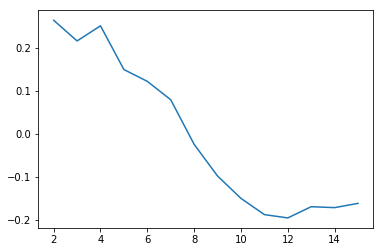

In [176]:
plt.plot(list(np.arange(14)+2), np.mean(np.array([[get_silhouette(i+2) for i in range(14)] for _ in range(10)]), axis=0))

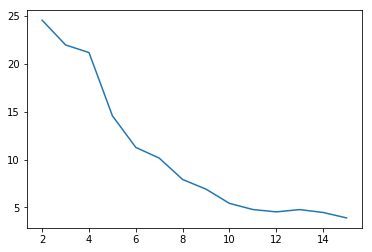

In [177]:
plt.plot(list(np.arange(14)+2), np.mean(np.array([[get_calinski(i+2) for i in range(14)] for _ in range(10)]), axis=0))

In [180]:
clusters = cluster.SpectralClustering(n_clusters=4)

clusters.fit(X)

labels = clusters.labels_

In [181]:
# color scale from min rate to max rate

def style_function(country):
    if country['id'] in label: 
        # country is in the dataframe
        cluster = labels[label.index(country['id'])]
        colors[cluster]
        return {
            'fillOpacity': 0.8,
            'weight': 0.5,
            'color': 'black',
            'fillColor': colors[cluster]
        }
    else:
        # country is not in the dataframe, hence we put its color as black
        return {
            'fillOpacity': 0.2,
            'weight': 0.2,
            'color': 'black',
            'fillColor': 'black'
        }
def highlight_function(i):
    return {
                'weight': 2,
                'fillOpacity': .2
            }
world_map = folium.Map([25, 0], tiles='', zoom_start=2)
g = folium.GeoJson(world_json_data, style_function=style_function, highlight_function=highlight_function).add_to(world_map)

del style_function
del highlight_function
world_map